In [1]:
cd("C:/Users/User/Downloads")

# Heterogenous treatment effects

### We will continue with the online discount example by Matteo Courthoud. That is, let's suppose we work in the analytics department of an online shop interested in understanding wether offering discounts to new customers increases their expenditure. In particular, we would like to know if offering discounts is more effective for some customers with respect to others, since we would prefer not to give discounts to customers that would spend anyways. Moreover, it could also be that spamming customers with pop-ups could deter them from buying, having the opposite effect.

### To understand whether and how much the discounts are effective we run an A/B test: whenever a new user visits our online shop, we randomly decide whether to offer them the discount or not. After 100 000 visits, we have collected the following dataset with relevant information beside the discount status (our treatment).

In [2]:
using CSV
using DataFrames

# Read the CSV file into a DataFrame
df = CSV.read("online_discounts.csv", DataFrame,
              types = Dict(:device => String, :browser => String, :region => String));
              
# Display the first few rows of the DataFrame
first(df, 5)

Row,Column1,time,device,browser,region,discount,spend
,Int64,Float64,String,String,String,Int64,Float64
1,0,10.779,mobile,edge,9,0,0.455164
2,1,0.568973,desktop,firefox,9,0,11.0369
3,2,3.74387,mobile,safari,7,0,1.81119
4,3,13.3734,desktop,other,5,0,31.9049
5,4,0.708575,mobile,explorer,2,1,15.4199


### Since the treatment was randomly assigned, we can use a simple difference-in-means estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the discount, therefore we can causally attribute any difference in spend to the discount

In [3]:
using GLM
using DataFrames

# Assuming df is already a DataFrame
# Fit the linear model
model = lm(@formula(spend ~ discount), df)

# Display the summary of the model
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spend ~ 1 + discount

Coefficients:
────────────────────────────────────────────────────────────────────────
               Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  5.12207   0.0454349  112.73    <1e-99    5.03302    5.21112
discount     1.75069   0.0642194   27.26    <1e-99    1.62482    1.87656
────────────────────────────────────────────────────────────────────────

### The discount seems to be effective: on average the spend in the treatment group increases by 1.75$. But are all customers equally affected? 

### To answer this question, we would like to estimate heterogeneous treatment effects, possibly at the individual level.



# Conditional Average Treatment Effects (CATE)

### There are many possible ways to estimate heterogenous treatment effects. The most common is to split the population in groups based on some observable characteristic, which in our case could be the device, the browser or the geographical region. Once you have decided which variable to split your data on, you can simply interact the treatment variable (discount) with the dimension of treatment heterogeneity. Let’s take device for example.

In [4]:
using GLM
using DataFrames

# Assuming df is already a DataFrame
# Fit the linear model with interaction term between discount and device
model = lm(@formula(spend ~ discount * device), df)

# Display the summary of the model
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spend ~ 1 + discount + device + discount & device

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                               Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                5.07574     0.0640853  79.20    <1e-99   4.95013     5.20135
discount                   1.08963     0.0906575  12.02    <1e-32   0.911944    1.26732
device: mobile             0.0929325   0.0907603   1.02    0.3059  -0.0849567   0.270822
discount & device: mobile  1.32109     0.128284   10.30    <1e-24   1.06966     1.57253
────────────────────────────────────────────────────────────────────────────────────────

### The interpretation of these results follows the same fashion as the previous ones: the effect of the discount on customers' spend is 1.08$, but it increases by a further 1.32$ if the customer is accessing the website from a mobile device.

### Splitting is easy for categorical variables, but for a continuous variable like time it is not intuitive where to split. Every hour? And which dimension is more informative? It would be temping to try all possible splits, but the more we split the data, the more it is likely that we find spurious results (i.e. we overfit, in machine learning lingo). It would be great if we could let the data speak and select the minimum and most informative splits.

### Moreover, the splitting problem must minimize the following objective function:

\begin{equation*}
\sum_{i}\left[\left(\tau_i-\hat{\tau} \left(X_i\right)\right)\right]
\end{equation*}


### Important issue: the objective function is unfeasible. A way out to this problem is to use Athey and Imbens (2016) outcome transformation

\begin{equation*}
Y_i^* =
\begin{cases}
 Y_i/p & W_i = 1 \\
-Y_i/(1-p) & W_i = 0
\end{cases}

\end{equation*}


### So, performing any predictive method to estimate $\hat{Y}_i^*$ will end up being th predicte CATE because 

\begin{equation*}

\mathbb{E}\left[Y_i^*|X_i=x\right] = \tau(x)

\end{equation*}

### That is, with this transformed variable we have transformed our treatment effect prediction problem to a plain outcome prediction problem. 

### A natural question arises from the definition transformed variable: what is $p$? $p$ is non other than the propensity score. That is, the probability of the individual of being treated. In an experimental study (like this one), we know this value beforehand. In observational studies, we would calculate it using a probit or logit regression. Eventhough we have programmed the discount to be given completely random (so we know $p=0.5$), it is advisable to estimate the propensity score to account for sample uncertainty.

In [5]:
using MLJ

y, X = unpack(df, ==(:spend), !=(:spend))
coerce!(X, Textual => Multiclass)
coerce!(X, Count => Multiclass)

Row,Column1,time,device,browser,region,discount
,Cat…,Float64,Cat…,Cat…,Cat…,Cat…
1,0,10.779,mobile,edge,9,0
2,1,0.568973,desktop,firefox,9,0
3,2,3.74387,mobile,safari,7,0
4,3,13.3734,desktop,other,5,0
5,4,0.708575,mobile,explorer,2,1
6,5,10.8321,desktop,brave,0,0
7,6,22.0928,desktop,safari,0,1
8,7,14.8808,desktop,chrome,3,0
9,8,11.1469,desktop,safari,2,0


In [6]:
D, X = unpack(X, ==(:discount), !=(:discount))

(CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 1, 0, 1, 0, 0, 1  …  1, 0, 1, 1, 0, 0, 0, 0, 0, 1], 100000×5 DataFrame
    Row │ Column1  time       device   browser   region 
        │ Cat…     Float64    Cat…     Cat…      Cat…   
────────┼───────────────────────────────────────────────
      1 │ 0        10.779     mobile   edge      9
      2 │ 1         0.568973  desktop  firefox   9
      3 │ 2         3.74387   mobile   safari    7
      4 │ 3        13.3734    desktop  other     5
      5 │ 4         0.708575  mobile   explorer  2
      6 │ 5        10.8321    desktop  brave     0
      7 │ 6        22.0928    desktop  safari    0
      8 │ 7        14.8808    desktop  chrome    3
   ⋮    │    ⋮         ⋮         ⋮        ⋮        ⋮
  99994 │ 99993    16.0944    desktop  edge      3
  99995 │ 99994     3.57947   desktop  chrome    4
  99996 │ 99995    14.2243    desktop  firefox   9
  99997 │ 99996    15.8043    desktop  other     5
  99998 │ 99997     2.36471   

In [7]:
using MLJModels


onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:device, :browser, :region])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

X = X[:,2:end]

┌ Info: Training machine(OneHotEncoder(features = [:device, :browser, :region], …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Spawning 2 sub-features to one-hot encode feature :device.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878
┌ Info: Spawning 7 sub-features to one-hot encode feature :browser.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878
┌ Info: Spawning 10 sub-features to one-hot encode feature :region.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878


Row,time,device__desktop,device__mobile,browser__brave,browser__chrome,browser__edge,browser__explorer,browser__firefox,browser__other,browser__safari,region__0,region__1,region__2,region__3,region__4,region__5,region__6,region__7,region__8,region__9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.779,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.568973,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.74387,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.3734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.708575,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.8321,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22.0928,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,14.8808,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11.1469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface

log_model = LogisticClassifier()

log_model_machine = machine(log_model,X, D)

fit!(log_model_machine)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\User\.julia\packages\MLJModels\ziReN\src\loading.jl:159


import MLJScikitLearnInterface ✔


┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
C:\Users\User\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @802 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @107 ⏎ AbstractVector{Multiclass{2}}


In [ ]:
pscore = pdf.(MLJ.predict(log_model_machine, X),1)

100000-element Vector{Float64}:
 0.5142146419087926
 0.5100085364972161
 0.49702531576346043
 0.4879660329572406
 0.5109496741490348
 0.5075633487291222
 0.5004810026849342
 0.5016481873441815
 0.4997925159452702
 0.49541904576951884
 ⋮
 0.4891853186539567
 0.4995247634315574
 0.5045728007984978
 0.5087262134483533
 0.5065792652936659
 0.4873557804652629
 0.5031095211499076
 0.5119182452419018
 0.5100448975009242

In [23]:
df

Row,Column1,time,device,browser,region,discount,spend,pscore
,Int64,Float64,String,String,String,Int64,Float64,Float64
1,0,10.779,mobile,edge,9,0,0.455164,0.514215
2,1,0.568973,desktop,firefox,9,0,11.0369,0.510009
3,2,3.74387,mobile,safari,7,0,1.81119,0.497025
4,3,13.3734,desktop,other,5,0,31.9049,0.487966
5,4,0.708575,mobile,explorer,2,1,15.4199,0.51095
6,5,10.8321,desktop,brave,0,0,24.1239,0.507563
7,6,22.0928,desktop,safari,0,1,14.351,0.500481
8,7,14.8808,desktop,chrome,3,0,30.9891,0.501648
9,8,11.1469,desktop,safari,2,0,-0.920616,0.499793


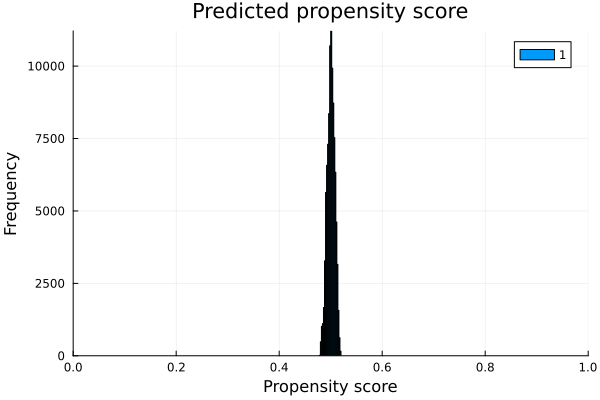

In [16]:
using Plots

histogram(pscore, bins=30, title="Predicted propensity score", label = "1",
         xlabel="Propensity score", ylabel="Frequency",xlims=(0, 1))

### As expected, the histogram of the propensity score reveals that the treatment is completely random. Now, with the estimated propensity score of each individual we can calculate $Y_i^*$

In [27]:
y_star = df.spend ./ (df.discount .* pscore .- (1 .- df.discount) .* (1 .- pscore))

100000-element Vector{Float64}:
  -0.9369657008690758
 -22.52461818809938
  -3.600962622574866
 -62.310209863416645
  30.178828077890405
 -48.98889302200439
  28.67440660987631
 -62.18314365432086
   1.8404682566881003
  17.224817753568892
   ⋮
 -30.524364832892832
   3.412446313106923
   5.907562360461293
   4.324339693714542
 -69.00301414389848
 -25.899574462271453
 -26.639690356229913
  -0.41521729572757315
   5.893502753357434

### As we said before, the idea is to use $Y_i^*$ as the target of a prediction problem, since the expected value is exactly the individual treatment effect. Let’s check its average in the data.

In [28]:
mean(y_star)

1.7579131574573155

### Although $Y_i^*$ is an unbiased estimator for the individual treatment effect, it has a very high variance

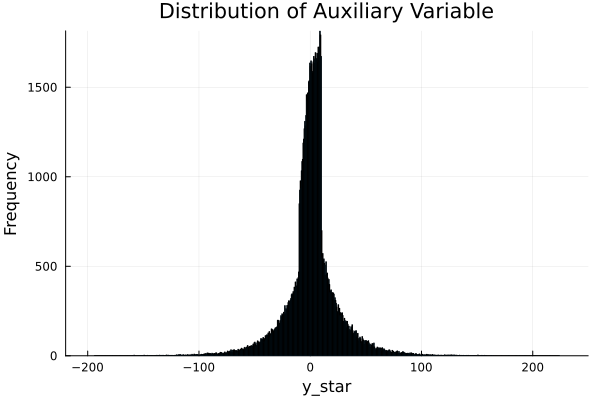

In [ ]:
histogram(y_star, bins=1000, title="Distribution of Auxiliary Variable", label = false,
         xlabel="y_star", ylabel="Frequency")     

### Now, with all the arguments given above, we can build a regression tree with the transformed outcome to calculate the predicted CATE

In [34]:
X

Row,time,device__desktop,device__mobile,browser__brave,browser__chrome,browser__edge,browser__explorer,browser__firefox,browser__other,browser__safari,region__0,region__1,region__2,region__3,region__4,region__5,region__6,region__7,region__8,region__9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.779,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.568973,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.74387,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.3734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.708575,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.8321,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22.0928,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,14.8808,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11.1469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X = select!(X, Not(:device__desktop, :browser__brave, :region__0))

Row,time,device__mobile,browser__chrome,browser__edge,browser__explorer,browser__firefox,browser__other,browser__safari,region__1,region__2,region__3,region__4,region__5,region__6,region__7,region__8,region__9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.779,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.568973,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.74387,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.3734,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.708575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.8321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22.0928,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,14.8808,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11.1469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)
tree_model = DecisionTreeRegressor(max_depth = 2)
tree_machine = machine(tree_model, X, y_star)
fit!(tree_machine);

┌ Info: Training machine(DecisionTreeRegressor(max_depth = 2, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


In [38]:
fitted_params(tree_machine)[1]

time < 12.74
├─ time < 8.755
│  ├─ 0.12698631389503207 (0/36390)
│  └─ 1.2002598689483608 (0/16519)
└─ browser__safari < 0.5
   ├─ 2.7612851100411784 (0/40415)
   └─ 5.953543032597246 (0/6676)


### Some caveats should be given about the results of this tree. First, the CATE estimates will be unbiased only if, within each leave, we have the same number of treated and control units. And second, we have used the same data to generate and evaluate the tree, which generates overfitting.

# Generating Splits

### Last but not least, how should the tree be generated? The default rule to generate splits minimizing the sum of squared errors metric, so there is no restriction on the minimum number of observations per leaf. Other commonly used rules include, mean absolute error, Gini’s impurity, and Shannon’s information. Which one performs better depends on the specific application, but the general objective is always prediction accuracy, broadly defined.

### In that regard, Athey and Imbens (2016) use a modified version of the Mean Squared Error (MSE) as splitting criterion, named the Expanded Mean Squared Error (EMSE)

\begin{equation*}

EMSE = \mathbb{E}\left[\left(Y_i-\hat{\mu}(X_i)\right)^2-Y_i^2\right]

\end{equation*}